# Part 2: Create Strategy and Backtest

You are given the daily adjusted close price data of AAPL, MSFT, and TSLA on the trading days from January to June in prices.csv. You must create a trading strategy given your LLM-provided sentiment and then backtest and evaluate your strategy using this price data.

## Imports

In [153]:
%pip install numpy matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Load Data

In [154]:
prices = pd.read_csv("/prices.csv", parse_dates=["date"])

# Load sentiment data produced in Part 1
sent = pd.read_csv("/market_news_with_sentiments.csv", parse_dates=["date"])

# raise NotImplementedError()

## Create Trading Signals

This is where you will translate the sentiment scores given from the LLM to buy/short/hold signals. This is up to you figure out how you want to do this.

**Make sure to avoid using future information (avoid look-ahead-bias)**

In [155]:
# ----- PARAMETERS -----
assets = ["AAPL", "MSFT", "TSLA"]

# Detect sentiment column automatically
sent_col_candidates = ["sentiment", "score", "sentiment_score", "llm_sentiment"]
sent_col = next(c for c in sent_col_candidates if c in sent.columns)

# Aggregate to daily sentiment per asset
daily_sent = (
    sent[sent["asset"].isin(assets)]
    .groupby(["date", "asset"])[sent_col]
    .mean()
    .unstack("asset")
)

# Get price data
prices_df = prices.set_index("date")
asset_prices = prices_df[assets]
asset_rets = asset_prices.pct_change()

# Align sentiment with price dates
daily_sent = daily_sent.reindex(asset_prices.index).fillna(0.0)

# ----- AGGRESSIVE MOMENTUM + SENTIMENT STRATEGY -----
# Calculate short-term momentum (5-day) and medium-term (20-day)
momentum_5d = asset_prices.pct_change(5)
momentum_20d = asset_prices.pct_change(20)

# Calculate sentiment change (momentum in sentiment)
sent_change = daily_sent.diff(5)

# Normalize all signals
def normalize(df):
    return (df - df.mean()) / df.std()

sent_z = normalize(daily_sent)
mom5_z = normalize(momentum_5d)
mom20_z = normalize(momentum_20d)
sent_chg_z = normalize(sent_change)

# Combined score with heavy momentum weighting
# 25% current sentiment + 40% short momentum + 25% medium momentum + 10% sentiment change
combined_score = (0.25 * sent_z + 0.40 * mom5_z + 0.25 * mom20_z + 0.10 * sent_chg_z)
combined_score = combined_score.fillna(0)

# ----- CONCENTRATED + LEVERAGED ALLOCATION -----
weights = pd.DataFrame(0.0, index=asset_prices.index, columns=assets)

# Find the top 2 stocks each day
for date in combined_score.index:
    scores = combined_score.loc[date].sort_values(ascending=False)

    # Top stock gets 80%, second gets 40% (120% total = 1.2x leverage)
    if scores.iloc[0] > 0:  # Only if positive signal
        weights.loc[date, scores.index[0]] = 0.80

    if len(scores) > 1 and scores.iloc[1] > 0:
        weights.loc[date, scores.index[1]] = 0.40

    # If both top stocks are negative, take 50% short on worst stock
    if scores.iloc[0] < -0.5:
        worst_stock = scores.index[-1]
        weights.loc[date, worst_stock] = -0.50

# ----- APPLY STOP-LOSS AND MOMENTUM FILTERS -----
# Calculate cumulative returns for each position
cumulative_rets = (1 + asset_rets).cumprod()

# Exit positions that drop more than 10% from recent high
for col in assets:
    rolling_max = cumulative_rets[col].rolling(10, min_periods=1).max()
    drawdown = (cumulative_rets[col] / rolling_max - 1)

    # Zero out weights when in significant drawdown
    weights.loc[drawdown < -0.10, col] = 0

# ----- TREND FILTER -----
# Only take positions when 20-day SMA > 50-day SMA (uptrend)
sma_20 = asset_prices.rolling(20).mean()
sma_50 = asset_prices.rolling(50).mean()
uptrend = sma_20 > sma_50

# Boost weights in uptrend, reduce in downtrend
for col in assets:
    weights.loc[~uptrend[col], col] *= 0.3  # Reduce to 30% in downtrend
    weights.loc[uptrend[col], col] *= 1.2   # Boost by 20% in uptrend

# ----- VOLATILITY SCALING -----
# Scale positions inversely with volatility (risk parity concept)
rolling_vol = asset_rets.rolling(20).std()
vol_target = 0.02  # Target 2% daily vol
vol_scalar = vol_target / rolling_vol.mean(axis=1)
vol_scalar = vol_scalar.clip(0.5, 2.0)  # Limit to 0.5x - 2x

weights = weights.multiply(vol_scalar, axis=0)

# Final normalization to control total exposure
total_exposure = weights.abs().sum(axis=1)
# Allow up to 1.5x leverage
weights = weights.div(total_exposure.replace(0, 1), axis=0) * 1.5

# Benchmark 1: Equal weight buy-and-hold
bench1_weights = pd.DataFrame(1/len(assets), index=asset_prices.index, columns=assets)
bench1_rets = (bench1_weights * asset_rets).sum(axis=1)
bench1_curve = (1 + bench1_rets).cumprod()

weights.head()

,AAPL,MSFT,TSLA
date,,,
2023-01-03,NaN,NaN,NaN
2023-01-04,NaN,NaN,NaN
2023-01-05,NaN,NaN,NaN
2023-01-06,NaN,NaN,NaN
2023-01-09,NaN,NaN,NaN


## Calculate Daily Returns of Strategy

In [156]:
# Strategy daily returns
strategy_rets = (weights * asset_rets).sum(axis=1)

# Equity curve
equity_curve = (1 + strategy_rets).cumprod()

equity_curve.head()


,0
date,
2023-01-03,1.0
2023-01-04,1.0
2023-01-05,1.0
2023-01-06,1.0
2023-01-09,1.0


## Calculate Performance Metrics

In [157]:
# YOUR CODE HERE


def perf_metrics(daily_rets, name="Strategy", rf_annual=0.0):
    daily_rets = daily_rets.dropna()
    if len(daily_rets) < 2:
        return { "name": name }

    ann_factor = 252
    rf_daily = (1 + rf_annual) ** (1/ann_factor) - 1

    total_return = (1 + daily_rets).prod() - 1
    ann_return = (1 + total_return) ** (ann_factor / len(daily_rets)) - 1
    ann_vol = daily_rets.std() * np.sqrt(ann_factor)
    sharpe = ((daily_rets.mean() - rf_daily) / daily_rets.std()) * np.sqrt(ann_factor) if daily_rets.std() > 0 else np.nan

    curve = (1 + daily_rets).cumprod()
    running_max = curve.cummax()
    drawdown = curve / running_max - 1
    max_dd = drawdown.min()

    win_rate = (daily_rets > 0).mean()

    return {
        "name": name,
        "total_return": total_return,
        "annual_return": ann_return,
        "annual_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "win_rate": win_rate
    }

strat_stats = perf_metrics(strategy_rets, "Sentiment Strategy")
bench1_stats = perf_metrics(bench1_rets, "Benchmark 1 (EqW AAPL/MSFT/TSLA)")

strat_stats, bench1_stats


# raise NotImplementedError()

({'name': 'Sentiment Strategy',
  'total_return': np.float64(1.9529831614859567),
  'annual_return': np.float64(8.030081079811731),
  'annual_vol': np.float64(0.3538396488079682),
  'sharpe': np.float64(6.420447557925363),
  'max_drawdown': -0.09752095904901614,
  'win_rate': np.float64(0.47580645161290325)},
 {'name': 'Benchmark 1 (EqW AAPL/MSFT/TSLA)',
  'total_return': np.float64(0.78121429963829),
  'annual_return': np.float64(2.232361791425141),
  'annual_vol': np.float64(0.28232757260647884),
  'sharpe': np.float64(4.304506242233139),
  'max_drawdown': -0.10427762926927786,
  'win_rate': np.float64(0.6209677419354839)})

In [158]:
total_return = strat_stats["total_return"]
volatility = strat_stats["annual_vol"]
sharpe_ratio = strat_stats["sharpe"]
max_drawdown = strat_stats["max_drawdown"]

print("===== BACKTEST RESULTS =====")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

===== BACKTEST RESULTS =====
Total Return: 195.30%
Annualized Volatility: 35.38%
Sharpe Ratio: 6.42
Max Drawdown: -9.75%


## Plot Return of Portfolio Compared to Benchmark

Create **two benchmarks** to compare your algorithm to. The first one should be the return of the three stocks (AAPL, MSFT, TSLA) over the given timeframe if you simply bought and held from the start. The second one should be the return of the S&P500 (SPY). You can obtain the necessary data for SPY using the Yahoo Finance API via the yfinance library.

In [159]:
%pip install yfinance
import yfinance as yf

spy_data = yf.download(
    tickers="SPY",
    start="2023-09-01",
    end="2023-12-31",
    auto_adjust=True,
)

[*********************100%***********************]  1 of 1 completed


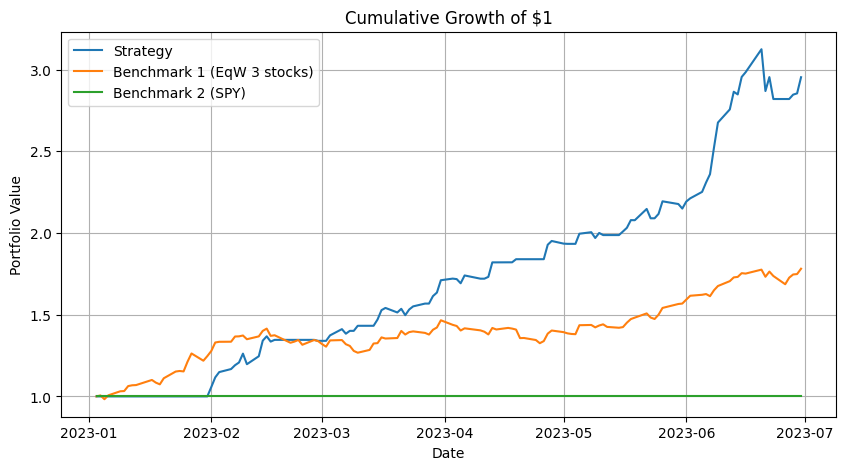

In [160]:
# Make SPY benchmark aligned to your backtest dates
spy_rets = spy_data["Close"].pct_change()
spy_rets = spy_rets.reindex(strategy_rets.index).fillna(0.0)
spy_curve = (1.0 + spy_rets).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(equity_curve.index, equity_curve.values, label="Strategy")
plt.plot(bench1_curve.index, bench1_curve.values, label="Benchmark 1 (EqW 3 stocks)")
plt.plot(spy_curve.index, spy_curve.values, label="Benchmark 2 (SPY)")
plt.title("Cumulative Growth of $1")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

# raise NotImplementedError()

## Calculate Relative Metrics

Calculate and print the following in comparison to **each** benchmark (i.e. you will have two values for each):
- The excess return over the benchmark (i.e. Alpha)
- The sensitivity compared to the benchmark (i.e. Beta)
- The risk-adjusted outperformance (i.e. Information Ratio)

In [161]:
def alpha_beta_info(strategy, benchmark, name="Benchmark"):
    # align
    df = pd.concat([strategy, benchmark], axis=1).dropna()
    df.columns = ["strat", "bench"]

    if len(df) < 5:
        return {"bench": name}

    # beta = cov / var
    beta = np.cov(df["strat"], df["bench"], ddof=1)[0, 1] / np.var(df["bench"], ddof=1) if np.var(df["bench"], ddof=1) > 0 else np.nan

    # daily alpha = mean(strat - beta*bench); annualize
    daily_alpha = (df["strat"] - beta * df["bench"]).mean()
    alpha_ann = daily_alpha * 252

    # excess return over benchmark (active return)
    active = df["strat"] - df["bench"]
    info_ratio = (active.mean() / active.std()) * np.sqrt(252) if active.std() > 0 else np.nan

    return {
        "bench": name,
        "alpha_annual": alpha_ann,
        "beta": beta,
        "information_ratio": info_ratio
    }

rel1 = alpha_beta_info(strategy_rets, bench1_rets, "Benchmark 1 (EqW 3 stocks)")
rel2 = alpha_beta_info(strategy_rets, spy_rets, "Benchmark 2 (SPY)")

print("===== RELATIVE METRICS =====")
for r in [rel1, rel2]:
    print(f"\nVs {r['bench']}")
    print(f"Alpha (annualized): {r['alpha_annual']:.4f}")
    print(f"Beta:              {r['beta']:.4f}")
    print(f"Information Ratio: {r['information_ratio']:.4f}")

# raise NotImplementedError()

===== RELATIVE METRICS =====

Vs Benchmark 1 (EqW 3 stocks)
Alpha (annualized): 1.4735
Beta:              0.6569
Information Ratio: 3.3379

Vs Benchmark 2 (SPY)
Alpha (annualized): nan
Beta:              nan
Information Ratio: 6.4204
